<a href="https://colab.research.google.com/github/soupsoupr/StrokeSegmentation/blob/main/test_epochs%3D20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and pre-process data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nibabel as nib
import os
# Set the file path to the directory containing the DWI data files
file_path = '/content/drive/MyDrive/ISLES/dataset-ISLES22^public^unzipped^version'

In [3]:
n = 50  # Number of data sets - there are 250 cases in total
data_list = []  # Initialize an empty list to store the data pairs

for example_case in range(1,n+1): # for the first 10 data from ISLES22
    # Set images path.
    dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
    mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

    dwi_data = nib.load(dwi_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()

    # Slice from the middle slice
    # slice_index = 40
    slice_index = dwi_data.shape[2] // 2

    # Extract the 2D slice from the 3D volume
    slice_dwi_data = dwi_data[:, :, slice_index]
    slice_mask_data = mask_data[:, :, slice_index]

    data_list.append((slice_dwi_data, slice_mask_data))

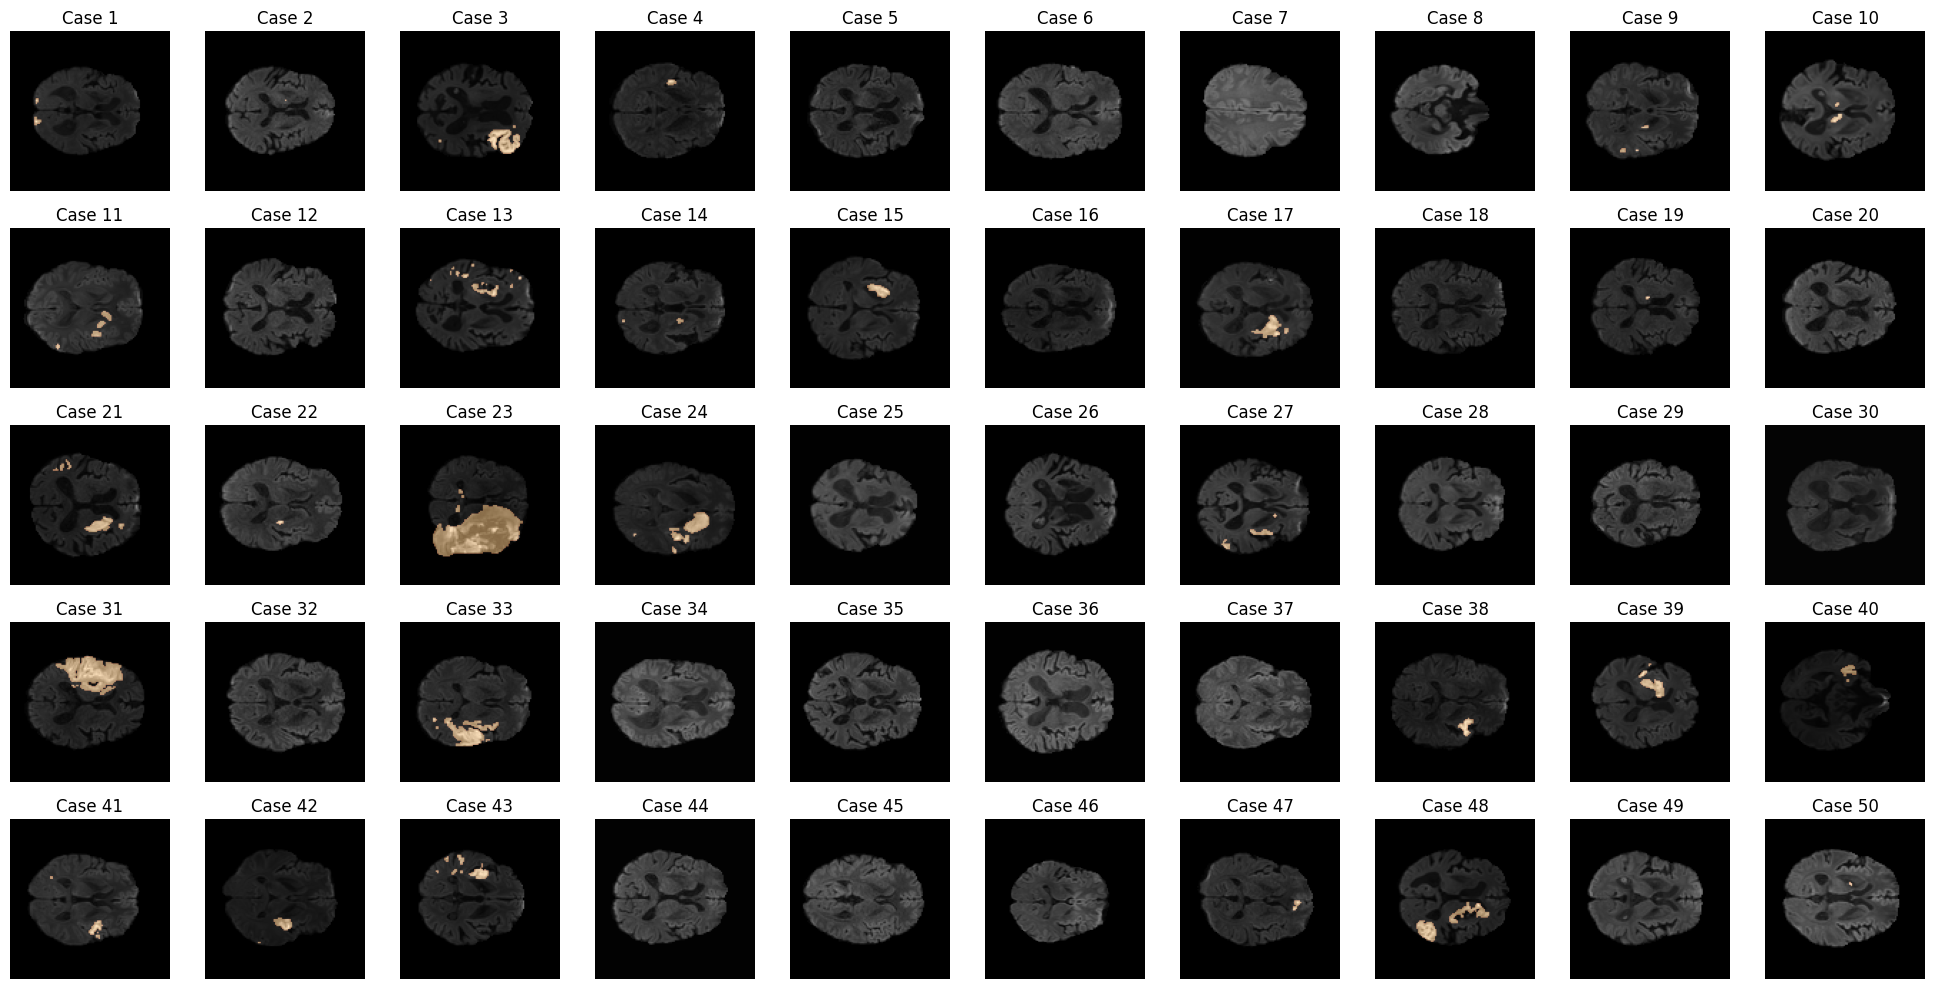

In [4]:
from PIL import Image
from matplotlib import pyplot as plt

# Create a figure with a 5x10 grid of subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

for i, (dwi_data, mask_data) in enumerate(data_list[:50]):
    row = i // 10  # Determine the row index
    col = i % 10   # Determine the column index

    axes[row, col].imshow(dwi_data, cmap='gray') # Plot DWI data
    axes[row, col].imshow(mask_data, alpha=0.5, cmap='copper') # Plot mask data

    axes[row, col].set_title(f'Case {i + 1}')

    # Hide axis labels and ticks
    for ax in plt.gcf().get_axes():
        ax.axis('off')

    plt.tight_layout() # Adjust spacing between subplots

# Import ibraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Split dataset into training and testing sets

In [6]:
from sklearn.model_selection import train_test_split

# separate data into X and y
X = [dwi_data for dwi_data, _ in data_list]  # Assuming DWI data is X
y = [pred_mask_data for _, pred_mask_data in data_list]  # Assuming mask data is y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom PyTorch dataset

In [7]:
class CustomDataset(Dataset):
    def __init__ (self, data_list, transformer):
        self.data_list = data_list
        self.transformer = transformer

    def __len__ (self):
        return len(self.data_list)

    def __getitem__ (self, index):
        dwi_data, mask_data = self.data_list[index]
        return dwi_data, mask_data

# Data preprocessing and augmentation

In [8]:
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# Create data loaders

In [9]:
# Train and test sets initalization
train_dataset = CustomDataset(data_list, train_transformer)
test_dataset = CustomDataset(data_list, test_transformer)

In [10]:
# Train and test set data loaders initalization
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Check data shape
*   shape form [in_channels, height, width]


In [11]:
# Iterate through the data loader
for batch_idx, (image, mask) in enumerate(train_loader):

    print(f'DWI image shape: {image.shape}')
    print(f'Mask shape: {mask.shape}')

    break

DWI image shape: torch.Size([1, 112, 112])
Mask shape: torch.Size([1, 112, 112])


# Define the U-Net Model

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x2 = self.decoder(x1)
        return x2

# Instantiate the U-Net model

In [13]:
in_channels = 1  # DWI images channels
out_channels = 1  # masks channel
model = UNet(in_channels, out_channels)

# Model training

In [18]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float()  # Convert input data to float32
        labels = labels.float()  # Convert labels data to float32

        outputs = model(inputs) # Forward pass

        loss = criterion(outputs, labels) # Calculate the loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print or log training loss for monitoring
        # print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Model evaluation

In [33]:
model.eval()  # Set the model to evaluation mode
total_loss = 0.0

# Initialize variables for evaluation metrics (e.g., accuracy, precision, recall)
correct_predictions = 0
total_predictions = 0

# Evaluation loop
with torch.no_grad():
    for i, (dwi_batch_eval, mask_batch_eval) in enumerate(test_loader):
        dwi_batch_eval = dwi_batch_eval.float()  # Convert input data to float32
        mask_batch_eval = mask_batch_eval.float() # Convert mask data to float32

        # Forward pass
        outputs_eval = model(dwi_batch_eval)

        # Calculate the loss (if needed)
        loss_eval = criterion(outputs_eval, mask_batch_eval)
        total_loss += loss_eval.item()

        # Calculate evaluation metrics (e.g., accuracy)
        predicted_masks = torch.argmax(outputs_eval, dim=1)
        correct_predictions += (predicted_masks == mask_batch_eval).sum().item()
        total_predictions += mask_batch_eval.numel()

        intersection = torch.sum(predicted_masks * mask_batch_eval)
        union = torch.sum(predicted_masks) + torch.sum(mask_batch_eval)

# Calculate average loss
average_loss = total_loss / len(test_loader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Calculate dice coefficient
dice_coefficient = (2.0 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero

# Calculate IoU
iou = intersection / (union + 1e-5)

# Print evaluation results
print(f'Evaluation Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Dice Coefficient: {dice_coefficient:.4f}')
print(f"IoU: {iou:.4f}")

Evaluation Loss: 24.1428
Accuracy: 8.63%
Dice Coefficient: 2.1424
IoU: 1.0712


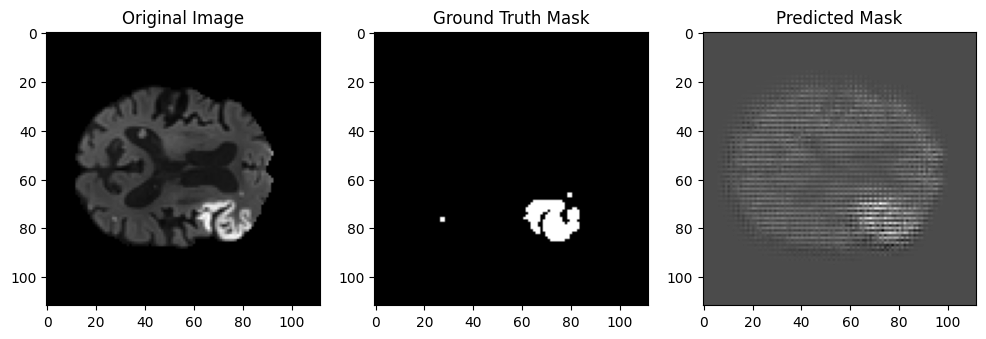

In [34]:
import torch

model = UNet(in_channels, out_channels)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for image, mask in test_loader:
        image = image.float()  # Convert input data to float32
        # Forward pass through the model to get predictions
        predicted_masks = model(image)

        # Detach the tensors if using GPU to avoid GPU memory issues
        predicted_masks = predicted_masks.cpu()
        image = image.cpu()
        mask = mask.cpu()

        # Visualize a few sample images and their corresponding predictions
        for j in range(min(5, image.size(0))):  # Visualize up to 3 samples
            plt.figure(figsize=(12, 4))

            # Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(image[j], cmap='gray')  # Assuming grayscale image
            plt.title("Original Image")

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask[j], cmap='gray')
            plt.title("Ground Truth Mask")

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[j], cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

        if i >= 5:  # Visualize predictions for the first 3 batches
            break